# APPLE N ORANGE CLASSIFICATION WITH RESNET18

# IMPORT LIBRARY

In [1]:
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# SETUP DAN TRANSFORMASI DATA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "/kaggle/input/fruitdataset/archive/fruit-dataset"
print(f"Using device: {device}")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

Using device: cuda


# LOAD DATASET DAN SPLIT

In [3]:
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
val_percent = 0.2
val_size = int(len(full_dataset) * val_percent)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = full_dataset.classes
print("Class names:", 'apple ,','orange')

Class names: apple , orange


# VISUALISASI SAMPEL GAMBAR

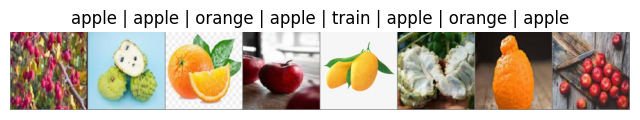

In [4]:
def imshow(img, title):
    img = img * 0.5 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

data_iter = iter(train_loader)
images, labels = next(data_iter)
imshow(torchvision.utils.make_grid(images[:8]), title=' | '.join([class_names[i] for i in labels[:8]]))

# LOAD MODEL RESNET18

In [5]:
from torchvision.models import ResNet18_Weights

model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


# TRAINING DAN EVALUASI


Epoch [1/20], Loss: 0.6088
Validation Accuracy: 75.00%


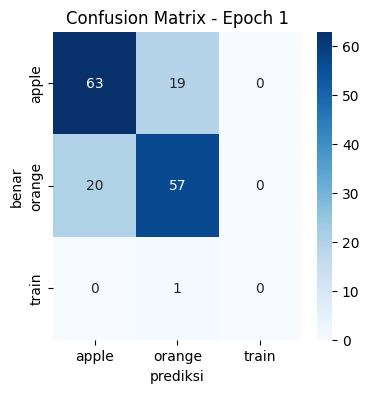


Epoch [2/20], Loss: 0.4654
Validation Accuracy: 83.12%


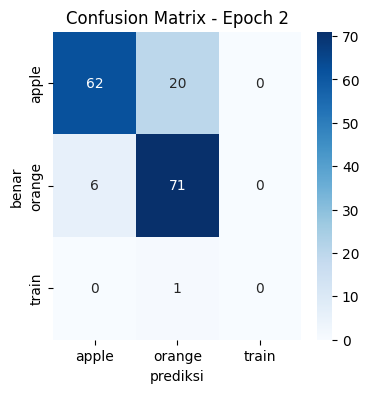


Epoch [3/20], Loss: 0.3991
Validation Accuracy: 81.88%


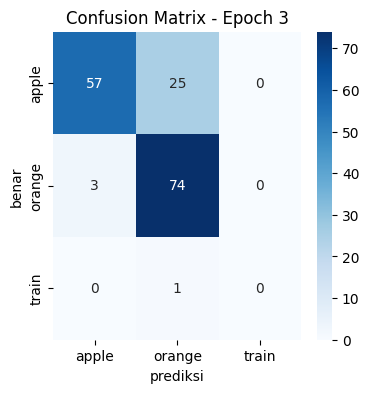


Epoch [4/20], Loss: 0.3181
Validation Accuracy: 87.50%


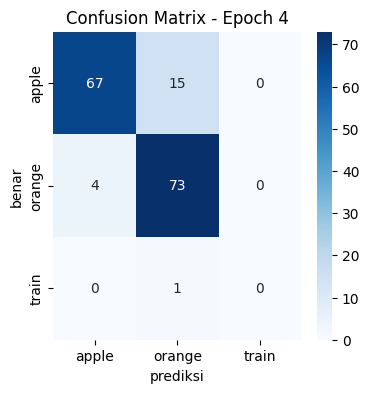


Epoch [5/20], Loss: 0.2863
Validation Accuracy: 90.00%


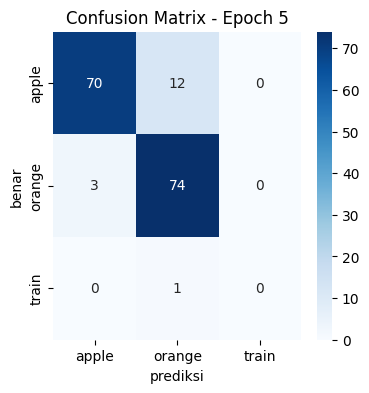


Epoch [6/20], Loss: 0.2792
Validation Accuracy: 90.00%


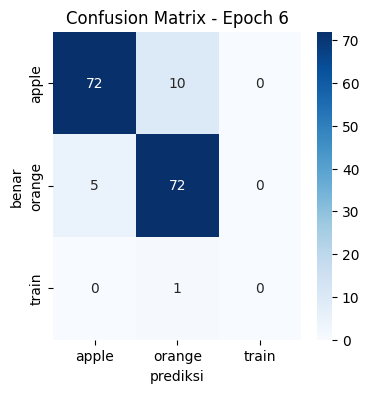


Epoch [7/20], Loss: 0.2545
Validation Accuracy: 86.88%


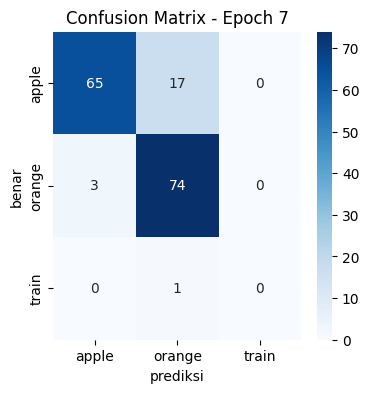


Epoch [8/20], Loss: 0.2672
Validation Accuracy: 85.62%


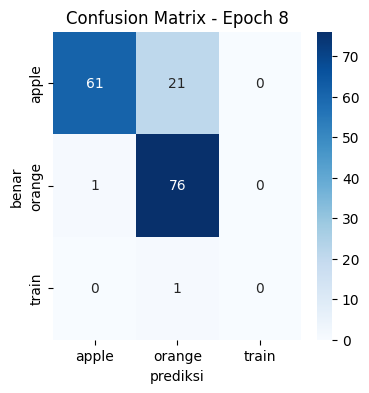


Epoch [9/20], Loss: 0.2042
Validation Accuracy: 89.38%


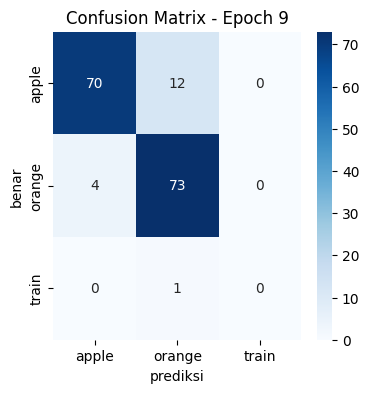


Epoch [10/20], Loss: 0.1898
Validation Accuracy: 90.62%


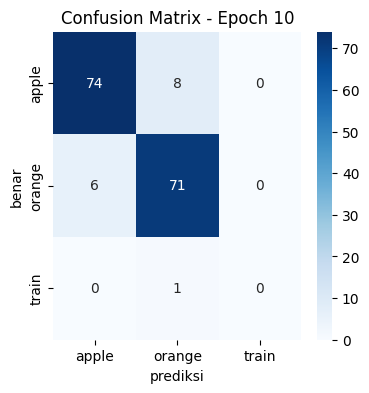


Epoch [11/20], Loss: 0.2364
Validation Accuracy: 88.75%


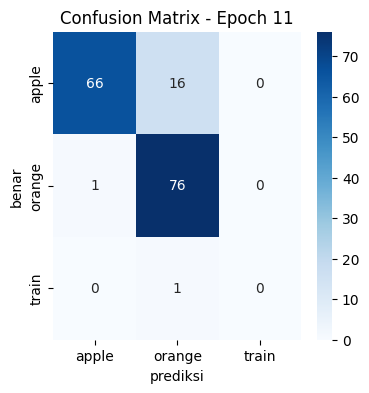


Epoch [12/20], Loss: 0.1670
Validation Accuracy: 90.62%


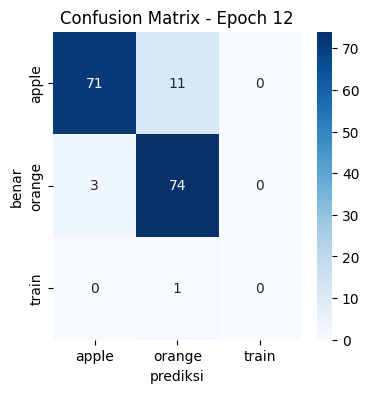


Epoch [13/20], Loss: 0.1617
Validation Accuracy: 91.25%


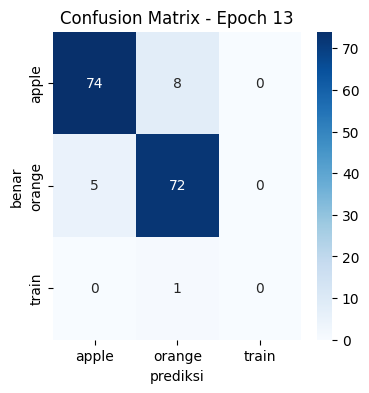


Epoch [14/20], Loss: 0.1446
Validation Accuracy: 90.62%


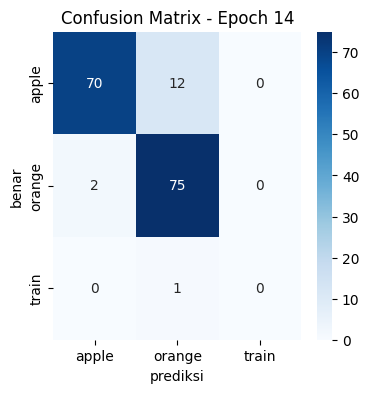


Epoch [15/20], Loss: 0.1404
Validation Accuracy: 90.62%


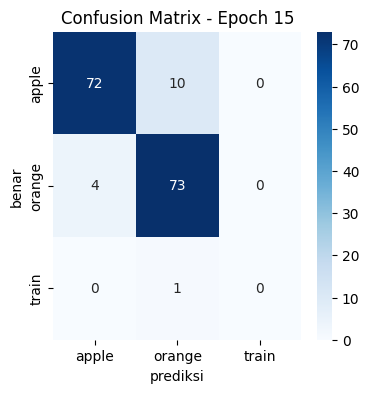


Epoch [16/20], Loss: 0.1360
Validation Accuracy: 90.62%


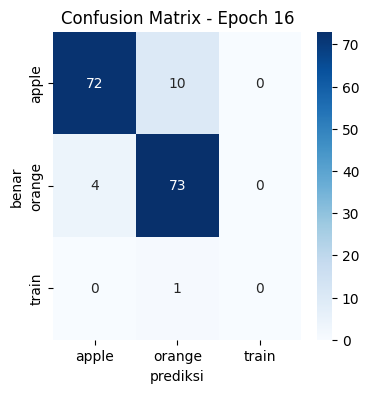


Epoch [17/20], Loss: 0.1247
Validation Accuracy: 91.25%


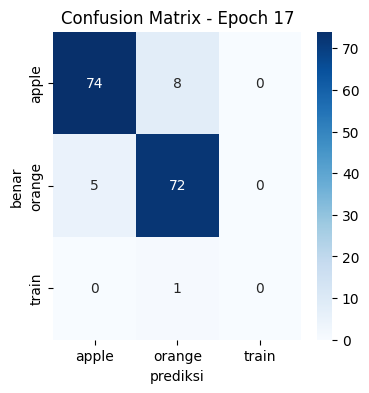


Epoch [18/20], Loss: 0.1235
Validation Accuracy: 88.75%


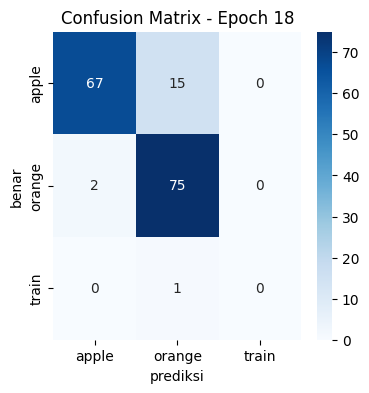


Epoch [19/20], Loss: 0.1515
Validation Accuracy: 91.25%


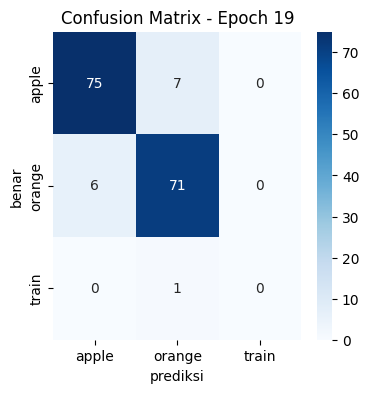


Epoch [20/20], Loss: 0.1154
Validation Accuracy: 91.88%


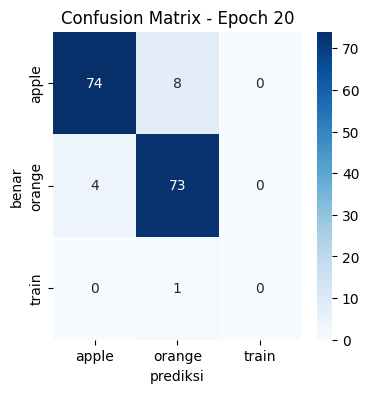

In [6]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.fc.parameters(), lr=0.001)

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs).round().squeeze()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Validation Accuracy: {acc*100:.2f}%")

    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("prediksi")
    plt.ylabel("benar")
    plt.title(f"Confusion Matrix - Epoch {epoch+1}")
    plt.show()

# PENGUJIAN GAMBAR 

Predicted: orange (Confidence: 99.90%)


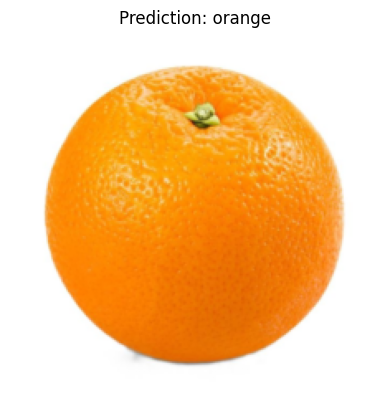

In [7]:
from PIL import Image

def predict_image(image_path, model, transform, class_names):
    # Load image
    image = Image.open(image_path).convert('RGB')
    
    # Apply same transform as test set
    image = transform(image).unsqueeze(0).to(device)

    # Set model to eval
    model.eval()
    with torch.no_grad():
        output = model(image)
        pred = torch.sigmoid(output).item()
        label = 1 if pred > 0.5 else 0
        confidence = pred if label == 1 else 1 - pred

    print(f"Predicted: {class_names[label]} (Confidence: {confidence*100:.2f}%)")

    # Show the image
    img_show = image.squeeze().cpu() * 0.5 + 0.5  # unnormalize
    npimg = img_show.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"Prediction: {class_names[label]}")
    plt.axis('off')
    plt.show()

# Contoh penggunaan:
# ganti '/kaggle/input/sampel/apple.jpg' dengan path gambar kamu
test_image_path = "/kaggle/input/fruitdataset/archive/fruit-dataset/train/jeruk.jpg"
predict_image(test_image_path, model, test_transform, class_names)
